## FinBERT-LL based Hate Speech (HS) Classification Experiment

# Preprocessing and 'HS strength' classifier 

### 6 labels (0, 1, 2, 3, 4, 5)

### Social Media Text Samples in Finnish

### 'raw' dataset text saples

### FinBert with all available training data - Merja's HS strength 'raw'  dataset

FinBERT-LL based sentiment and hate speech (HS) classification models use pre-trained Finnish language model of BERT.

The scripts were created and published by Merja Kreivi-Kauppinen, and
are part of research work carried in University of Oulu in 2020-2023.

The study is reported on (Master’s Thesis) research paper - 
Merja Kreivi-Kauppinen (2024) Hate Speech Detection of Dialectal, Granular and Urban Finnish. 
University of Oulu, Degree Programme in Computer Science and Engineering. Master’s Thesis.

## Check tensorflow, cuda, pytorch, jupyter, python  installations

In [1]:
import sys, re, os, openpyxl
import tqdm
from tqdm import tqdm
import tqdm as notebook_tqdm

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from torch.cuda.amp import autocast, GradScaler

print(f"\nPython Version: {sys.version} \n")
print(sys.executable)
print(sys.version)
print(sys.version_info)
print('\njupyter version: \n')
!jupyter --version

#import tensorboard
#print('\ntensorboard version: ', tensorboard.__version__)

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")

print('Torch version: ', torch.__version__)
#print('torchtext version', torchtext.__version__)

# Check nvidia version
print('\nvcc nvidia version: \n')
!nvcc --version

print('\n\ncudatoolkit version:')


Python Version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)] 

C:\Users\merja\anaconda3\envs\NLPtfgpu\python.exe
3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)

jupyter version: 

Selected Jupyter core packages...
IPython          : 8.5.0
ipykernel        : 6.16.0
ipywidgets       : 8.0.2
jupyter_client   : 7.4.2
jupyter_core     : 4.11.1
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.7.0
nbconvert        : 7.2.1
nbformat         : 5.7.0
notebook         : 6.4.12
qtconsole        : not installed
traitlets        : 5.4.0
Tensor Flow Version: 2.5.0
Keras Version: 2.5.0
Torch version:  1.12.1

vcc nvidia version: 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:59:34_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_

In [2]:
conda list cudatoolkit

# packages in environment at C:\Users\merja\anaconda3\envs\NLPtfgpu:
#
# Name                    Version                   Build  Channel
cudatoolkit               11.6.0              hc0ea762_10    conda-forge

Note: you may need to restart the kernel to use updated packages.


In [3]:
# check GPU
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT available")

# check torch cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

GPU is available


device(type='cuda', index=0)

In [4]:
# empty cuda
torch.cuda.empty_cache()

### Import python packages and libraries

In [5]:
# import python packages and libraries

import time, datetime, random, string
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

import transformers
print('Transformers version: ', transformers.__version__)

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# set seaborn figures
%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sns.set(style='darkgrid', palette='muted', font_scale=1.0)

Transformers version:  4.21.2
The scikit-learn version is 1.1.2.


## Initialize the Bert tokenizer

In [6]:
# FinBERT is included in HuggingFace transformers library.
# Download the pretrained FinBert model as "TurkuNLP/bert-base-finnish-cased-v1"
FinBERT = "TurkuNLP/bert-base-finnish-cased-v1"

# Set FinBert tokenizer as "TurkuNLP/bert-base-finnish-cased-v1"
BERT_TOKENIZER = BertTokenizer.from_pretrained(FinBERT)

# get the size of tokenizer
print('Tokenizer vocab size : ', len(BERT_TOKENIZER))

# import Bert pretrained model
BERT_MODEL = BertModel.from_pretrained("TurkuNLP/bert-base-finnish-cased-v1")

Tokenizer vocab size :  50105


Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Download data sets for training - only Merja's data

In [7]:
# import data from xlsx file to pd dataFolder
cwd = os.getcwd()
folder = '\\data\\'
csv_file = 'Manually_Annotated_Collection_ALL_FINAL_22023Merja.xlsx'
csv_source = cwd + folder + csv_file
#print(csv_source)

df = pd.read_excel(csv_source)
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,negative,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",negative,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria
2,3,--´973´¤-.ttu,negative,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria
3,4,-=>Widdu joo<=-,negative,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",negative,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,False,0,NaN,NaN,NaN,JOY,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,😂😂😂😂😂,Meria
6625,6626,😠👉👩‍💼,negative,-3,False,0,NaN,NaN,NaN,ANGER HATE,😠👉👩‍💼,😠👉👩‍💼,Meria
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,False,0,NaN,NaN,NaN,JOY,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,Meria
6627,6628,🤮😡,negative,-4,False,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",🤮😡,🤮😡,Meria


In [8]:
# Change text samples to string
df["text"] = df[str("sample")]

# add string len column
df["stringLength"] = ""

# extract string length measures of data
def extract_stringLen(df):
    for item in df["text"]:
        #newframe["stringLength"] = len(str(item))
        df["stringLength"] = df.text.str.len()
    return df

extract_stringLen(df)
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,text,stringLength
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,negative,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",negative,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,3,--´973´¤-.ttu,negative,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria,--´973´¤-.ttu,15
3,4,-=>Widdu joo<=-,negative,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria,-=>Widdu joo<=-,16
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",negative,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria,"- Ei , mutta olen joutunut elämään katsomalla ...",148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,False,0,NaN,NaN,NaN,JOY,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,😂😂😂😂😂,Meria,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14
6625,6626,😠👉👩‍💼,negative,-3,False,0,NaN,NaN,NaN,ANGER HATE,😠👉👩‍💼,😠👉👩‍💼,Meria,😠👉👩‍💼,5
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,False,0,NaN,NaN,NaN,JOY,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,Meria,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
6627,6628,🤮😡,negative,-4,False,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",🤮😡,🤮😡,Meria,🤮😡,2


In [9]:
df_raw_samples = df[['HSstrength', 'text', 'stringLength']].copy()
df_raw_samples

,HSstrength,text,stringLength
0,0,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,0,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,2,--´973´¤-.ttu,15
3,2,-=>Widdu joo<=-,16
4,0,"- Ei , mutta olen joutunut elämään katsomalla ...",148
...,...,...,...
6624,0,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14
6625,0,😠👉👩‍💼,5
6626,0,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
6627,0,🤮😡,2


## Concatenate training data

In [10]:
# Concatenate training data
new_df = df_raw_samples
new_df

,HSstrength,text,stringLength
0,0,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,0,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,2,--´973´¤-.ttu,15
3,2,-=>Widdu joo<=-,16
4,0,"- Ei , mutta olen joutunut elämään katsomalla ...",148
...,...,...,...
6624,0,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14
6625,0,😠👉👩‍💼,5
6626,0,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
6627,0,🤮😡,2


In [11]:
# Indicate missing values.
#df.isna
new_df.isna().sum().sum()

0

In [12]:
# Drop the rows where at least one element is missing.
df = new_df.dropna()
df

,HSstrength,text,stringLength
0,0,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,0,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,2,--´973´¤-.ttu,15
3,2,-=>Widdu joo<=-,16
4,0,"- Ei , mutta olen joutunut elämään katsomalla ...",148
...,...,...,...
6624,0,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14
6625,0,😠👉👩‍💼,5
6626,0,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
6627,0,🤮😡,2


In [13]:
# Indicate missing values.
#df.isna
df.isna().sum().sum()

0

In [14]:
# change polarity int64 values to int32
df['HSstrength'] = df['HSstrength'].astype('int32')
type(df['HSstrength'].iloc[0])

numpy.int32

In [15]:
# remove doubles
new_df = df.drop_duplicates(subset=['text'])
df = new_df
df

,HSstrength,text,stringLength
0,0,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,0,"- Kaivovertauksessa, viime hallitus on kaivan...",984
2,2,--´973´¤-.ttu,15
3,2,-=>Widdu joo<=-,16
4,0,"- Ei , mutta olen joutunut elämään katsomalla ...",148
...,...,...,...
6624,0,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14
6625,0,😠👉👩‍💼,5
6626,0,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10
6627,0,🤮😡,2


### Analyze Concatenated Sentiment Data

In [16]:
# Define the longest string length in data
print("Max text data length is:  ", df.text.str.len().max())

Max text data length is:   1041


Min text data length is:   1
Max text data length is:   824
Mean text data length is:   57.285865617433416
The standard deviation is:   93.13533624869677
The data count is:   6608


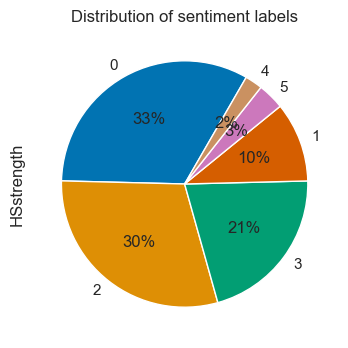

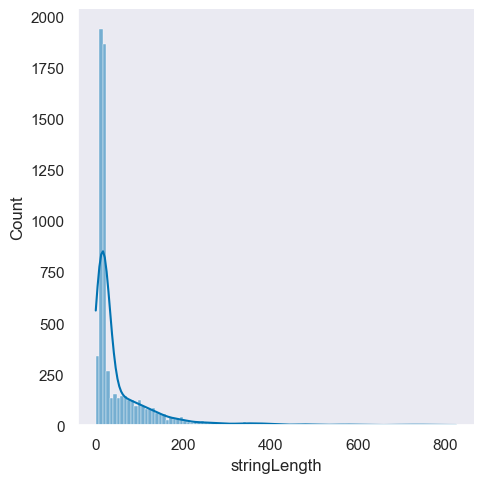

In [17]:
#MIN_LENGTH = int(2)
MIN_LENGTH = int(0)
MAX_LENGTH = int(850)

minDF = df[df["stringLength"] > MIN_LENGTH]
largeDF = minDF[minDF["stringLength"] <= MAX_LENGTH] 
#largeDF

print("Min text data length is:  ", largeDF.text.str.len().min())

# Define the longest string length in data
print("Max text data length is:  ", largeDF.text.str.len().max())

# Define the mean string length in data
print("Mean text data length is:  ", largeDF.text.str.len().mean())

# Define the standard deviation in string length
print("The standard deviation is:  ", largeDF["stringLength"].std())

# Define len of data
print("The data count is:  ", len(largeDF))

sns.set_theme(style='dark', palette='colorblind', font_scale=1.0)
rcParams['figure.figsize'] = 3, 3

largeDF['HSstrength'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%', 
                                          #colors=['silver', 'pink'], 
                                          #explode = (0.05, 0.05), 
                                          startangle=60, 
                                          title='Distribution of sentiment labels')

sns.displot(largeDF, x="stringLength", bins=103, kde=True)
#sns.pairplot(largeDF, hue='sentiment')
#largeDF

In [18]:
# Define groups 64, 128, 256, 850 and all samples

xshortSamples = df[df["stringLength"] <= 64 ] 
print("data size of xshort Samples ", len(xshortSamples))

shortSamples = df[df["stringLength"] <= 128]
print("data size of short Samples ", len(shortSamples))

mediumSamples = df[df["stringLength"] <= 256]
print("data size of medium Samples ", len(mediumSamples))

longSamples = df[df["stringLength"] <= 850]
print("data size of long Samples ", len(longSamples))

print("data size of all Samples ", len(df))

data size of xshort Samples  4975
data size of short Samples  5825
data size of medium Samples  6347
data size of long Samples  6608
data size of all Samples  6628


### Check tokenization lengths of concatenated training data

#### Max and min tokenization lengths - - - Special tokens not added !!!

Max length of tokenized sample:  231
Min length of tokenized sample:  1


(array([2.685e+03, 1.864e+03, 4.730e+02, 4.210e+02, 2.470e+02, 2.350e+02,
        1.560e+02, 8.500e+01, 7.800e+01, 4.900e+01, 4.100e+01, 3.500e+01,
        2.100e+01, 3.800e+01, 2.000e+01, 2.300e+01, 2.400e+01, 9.000e+00,
        1.100e+01, 1.000e+01, 8.000e+00, 8.000e+00, 8.000e+00, 3.000e+00,
        7.000e+00, 6.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 3.000e+00,
        3.000e+00, 5.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1. ,   5.6,  10.2,  14.8,  19.4,  24. ,  28.6,  33.2,  37.8,
         42.4,  47. ,  51.6,  56.2,  60.8,  65.4,  70. ,  74.6,  79.2,
         83.8,  88.4,  93. ,  97.6, 102.2, 106.8, 111.4, 116. , 120.6,
        125.2, 129.8, 134.4, 139. , 143.6, 148.2, 152.8, 157.4, 162. ,
        166.6, 171.2, 175.8, 180.4, 185. , 189.6, 194.2, 198.8, 203.4,
        208. , 212.6,

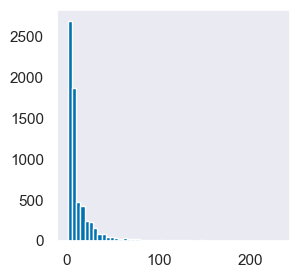

In [19]:
# Max and min tokenization lengths for all data
# Special tokens not added !!!

# Put inputs in x
#x = mediumDF["text"].values
x = largeDF["text"].values

# Encode concatenated data WITHOUT SPECIAL TOKENS

# Return Numpy np.ndarray objects as 'np'
encoded = [BERT_TOKENIZER.encode(text=sample,
                                 text_pair=None,
                                 add_special_tokens=False,
                                 padding=False,
                                 truncation=False,
                                 #max_length = MAX_LENGTH,
                                 is_split_into_words=False) for sample in x]

# Find the maximum length
max_len = max([len(sample) for sample in encoded])
print('Max length of tokenized sample: ', max_len)

# Find the minimum length
min_len = min([len(sample) for sample in encoded])
print('Min length of tokenized sample: ', min_len)

token_lens = []
for sample in x:
    encoded_tokens = BERT_TOKENIZER.encode(sample, add_special_tokens=False)
    token_len = len(encoded_tokens)
    token_lens.append(token_len)

#create histogram with 4 bins
plt.hist(token_lens, bins=50)

#### Max and min tokenization lengths - - - Special tokens added

Max length of tokenized sample:  233
Min length of tokenized sample:  3


(array([2.685e+03, 1.864e+03, 4.730e+02, 4.210e+02, 2.470e+02, 2.350e+02,
        1.560e+02, 8.500e+01, 7.800e+01, 4.900e+01, 4.100e+01, 3.500e+01,
        2.100e+01, 3.800e+01, 2.000e+01, 2.300e+01, 2.400e+01, 9.000e+00,
        1.100e+01, 1.000e+01, 8.000e+00, 8.000e+00, 8.000e+00, 3.000e+00,
        7.000e+00, 6.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 3.000e+00,
        3.000e+00, 5.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  3. ,   7.6,  12.2,  16.8,  21.4,  26. ,  30.6,  35.2,  39.8,
         44.4,  49. ,  53.6,  58.2,  62.8,  67.4,  72. ,  76.6,  81.2,
         85.8,  90.4,  95. ,  99.6, 104.2, 108.8, 113.4, 118. , 122.6,
        127.2, 131.8, 136.4, 141. , 145.6, 150.2, 154.8, 159.4, 164. ,
        168.6, 173.2, 177.8, 182.4, 187. , 191.6, 196.2, 200.8, 205.4,
        210. , 214.6,

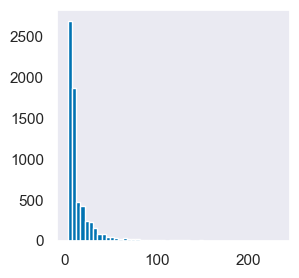

In [20]:
# Max and min tokenization lengths for all data
# Special tokens not added !!!

# Put inputs in x
#x = mediumDF["text"].values
x = largeDF["text"].values

# Encode concatenated data WITHOUT SPECIAL TOKENS

# Return Numpy np.ndarray objects as 'np'
encoded = [BERT_TOKENIZER.encode(text=sample,
                                 #text_pair=None,
                                 add_special_tokens=True,
                                 padding=False,
                                 truncation=False,
                                 #max_length = MAX_LENGTH,
                                 is_split_into_words=False) for sample in x]

# Find the maximum length
max_len = max([len(sample) for sample in encoded])
print('Max length of tokenized sample: ', max_len)

# Find the minimum length
min_len = min([len(sample) for sample in encoded])
print('Min length of tokenized sample: ', min_len)

token_lens = []
for sample in x:
    encoded_tokens = BERT_TOKENIZER.encode(sample, add_special_tokens=True)
    token_len = len(encoded_tokens)
    token_lens.append(token_len)
    
#create histogram with 4 bins
plt.hist(token_lens, bins=50)

## Define datasets, samplers, and dataloaders

In [21]:
type(df['HSstrength'].iloc[0])

numpy.int32

In [22]:
# set dataset
# set string length for dataset samples
min_length = int(0)
max_length = int(850)
minDF = df[df["stringLength"] > min_length]
largeDF = minDF[minDF["stringLength"] <= max_length]
df = largeDF

# set labels
labels = {'0':0,
          '1':1,
          '2':2,
          '3':3,
          '4':4,
          '5':5,
          }

# set MAX_LENGTH
MAX_LENGTH = 240

# define batch size - 2, 4, 8, 16, 32, 64, or 128
batch_size = 16

In [23]:
# randomize everything
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

train_data, val_data, test_data = np.split(df.sample(frac=1, random_state=RANDOM_SEED),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(train_data), len(val_data), len(test_data))

5286 661 661


In [24]:
# set dataset class

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        
        #self.labels = [labels[label] for label in df['category']]
        
        self.labels = [label for label in df['HSstrength']]
        
        self.texts = [BERT_TOKENIZER(text,
                                     #text_pair=None,
                                     add_special_tokens=True,
                                     # padding method - do not touch
                                     padding='max_length',
                                     max_length = MAX_LENGTH, 
                                     truncation=True,
                                     return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_texts, batch_labels


In [25]:
# create tensor data sets
train_dataset, val_dataset, test_dataset = Dataset(train_data), Dataset(val_data), Dataset(test_data)
len(train_dataset), len(val_dataset), len(test_dataset)

(5286, 661, 661)

In [26]:
# create DataLoaders (use weight sampler for train dataset only)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

## Define Bert Classifier

In [27]:
#freeze the pretrained layers 
#for param in bert.parameters(): 
    #param.requires_grad = False

class BertClassifier(nn.Module):
    def __init__(self, config):
        super(BertClassifier, self).__init__()
        
        input_size = config.input_size
        fc_neurons0 = config.num_affine_neurons0
        fc_neurons1 = config.num_affine_neurons1
        num_of_classes = config.num_of_classes
        dropout_value = config.dropout_value
        
        self.bert = BERT_MODEL
        
        # dropout layer
        self.dropout1 = nn.Dropout(dropout_value)
        
        # dense layer 1
        self.linear1 = nn.Linear(fc_neurons1, input_size)
        
        # relu activation function
        self.relu1 = nn.ReLU()
        
        # dropout layer
        self.dropout2 = nn.Dropout(dropout_value)
        
        # dense layer 2 (output layer)
        self.linear2 = nn.Linear(fc_neurons0, num_of_classes)
        #self.relu2 = nn.ReLU()
        
        #softmax activation function 
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_id, mask):
        
        # pass the inputs of bert tokenization to the model
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        
        output = self.dropout1(pooled_output)
        output = self.linear1(output)
        output = self.relu1(output)
        output = self.dropout2(output)
        
        # output layer
        output = self.linear2(output)
        #output = self.relu2(output)
        
        # softmax activation 
        output = self.softmax(output) 
        
        return output


In [28]:
# instantiate model config
class config:
    def __init__(self):
        # input_size
        config.input_size = MAX_LENGTH
        # number of nodes on linear layer, original 768
        config.num_affine_neurons0 = MAX_LENGTH
        # number of nodes on linear layer, original 768
        config.num_affine_neurons1 = 768
        # original num_of_classes
        config.num_of_classes = 6
        # original dropout values: 0.5 / 0.3 / 0.2
        config.dropout_value = 0.5
        return None

# instantiate and check network
bertConfig = config()
model = BertClassifier(bertConfig)
model

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50105, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

## Training and Validation Functions

Train the model. The training loop is a standard PyTorch training loop.

In [29]:
# training function

def training(model, dataloader, optimizer, criterion):
    
    # train all samples in one epoch
    print('\nEpoch {:} / {:} -----------------------------------------'.format(epoch + 1, epochs))
    """ 
    if (epoch % 10 >= 9):
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.000001, eps=1e-8)
    
    if (epoch % 10 >= 9):
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.000005)
    """
    # reset results before epoch
    total_train_loss = 0
    total_train_f1 = 0
    total_train_accuracy = 0

    # set model into training mode
    model.train()

    # for each batch of training dataset get dataloader
    for batch_index, data in enumerate(dataloader):
        
        #print("Batch index: ", batch_index)
        train_input, train_label = data

        true_labels = train_label.to(device)
        mask = train_input['attention_mask'].to(device)
        input_features = train_input['input_ids'].squeeze(1).to(device)
        
        # forward propagation (evaluate model on training batch)
        output = model(input_features, mask)
        
        # calculate cross entropy loss for batch
        batch_loss = criterion(output, true_labels.long())
        
        # collect the training losses of all batches (to calculate average loss later)
        total_train_loss += batch_loss.item()
                
        model.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        # get predicted results from tensor
        _, predicted = torch.max(output, 1)

        # move logits and labels to CPU for results calculation
        predicted = predicted.detach().cpu().numpy()
        y_true = true_labels.detach().cpu().numpy()

         # calculate f1-score
        total_train_f1 += f1_score(y_true, predicted, 
                                   average='weighted', 
                                   labels=np.unique(predicted))
        # calculate accuracy
        total_train_accuracy += accuracy_score(y_true, predicted, 
                                               #normalize=False, 
                                               normalize=True,
                                               sample_weight=None)
    
    # update the learning rate ------------------------------------------------------------
    #scheduler.step()

    # calculate the average loss over all of the batches (one epoch)
    avg_train_loss = total_train_loss / len(dataloader)

    # calculate the average f1 over all of the batches (one epoch)
    avg_train_f1 = total_train_f1 / len(dataloader)
    
    # calculate the accuracy of over all of the batches (one epoch)
    avg_train_accuracy = total_train_accuracy / len(dataloader)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Train Loss': avg_train_loss,
            'Train f1': avg_train_f1,
            'Train Accuracy': avg_train_accuracy
        }
    )

    # print results
    print("\nTraining results as average of bathes in one epoch")
    print("epoch | train loss | train f1 | train accuracy ")
    print(f"{epoch+1:5d} | {avg_train_loss:.5f} | {avg_train_f1:.5f} | {avg_train_accuracy:.5f}")
    
    # clear cuda
    torch.cuda.empty_cache()

    return None


In [30]:
# validating function

def validating(model, dataloader, criterion):
    
    # put the model in evaluation mode
    model.eval()

    # empty variables for storage
    total_valid_accuracy = 0
    total_valid_loss = 0
    total_valid_f1 = 0
    total_valid_recall = 0
    total_valid_precision = 0
    
    # evaluate data for one epoch
    for batch_index, data in enumerate(dataloader):
        
        #print("Batch index: ", batch_index)
        val_input, val_label = data

        # unpack batch from dataloader
        true_labels = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)

        # do not calculate gradients - gradients only for training
        with torch.no_grad():

            # forward propagation (evaluate model on validation data)
            output = model(input_id, mask)

            # calculate loss with loss criterion
            loss = criterion(output, true_labels.long())

            # calculate preds
            _, predicted = torch.max(output, 1)

        # collect validation loss values
        total_valid_loss += loss.item()

        # move logits and labels to CPU
        predicted = predicted.detach().cpu().numpy()
        y_true = true_labels.detach().cpu().numpy()
        
        # calculate accuracy
        total_valid_accuracy += accuracy_score(y_true, predicted, 
                                               normalize=True,
                                               sample_weight=None)
        # calculate f1
        total_valid_f1 += f1_score(y_true, predicted, 
                                   average='weighted', 
                                   labels=np.unique(predicted), 
                                   zero_division=0)
        # calculate precision
        total_valid_precision += precision_score(y_true, predicted, 
                                                 average='weighted', 
                                                 labels=np.unique(predicted), 
                                                 zero_division=0)
        # calculate recall
        total_valid_recall += recall_score(y_true, predicted, 
                                           average='weighted',
                                           labels=np.unique(predicted),
                                           zero_division=0)
        
    # get the average accuracy of validation run
    avg_valid_accuracy = total_valid_accuracy / len(dataloader)

    # get the average f1 of validation run
    #global avg_val_f1
    avg_valid_f1 = total_valid_f1 / len(dataloader)

    # get the average precision of validation run
    avg_valid_precision = total_valid_precision / len(dataloader)

    # get the average recall of validation run
    avg_valid_recall = total_valid_recall / len(dataloader)

    # get the average valid loss over all samples in validation batches
    avg_valid_loss = total_valid_loss / len(dataloader)

    # record the (average) results of validation batches
    valid_stats.append(
        {
            'Val Loss': avg_valid_loss,
            'Val Precision': avg_valid_precision,
            'Val Recall': avg_valid_recall,
            'Val f1': avg_valid_f1,
            'Val Accuracy': avg_valid_accuracy
        }
    )
    
    # print results
    print("\nValidation results as average for all validation batches")
    print("epoch | valid loss | valid f1 | valid accuracy")
    print(f"{epoch+1:5d} | {avg_valid_loss:.5f} | {avg_valid_f1:.5f} | {avg_valid_accuracy:.5f} ")
    print(" ")

    return None

## Training

In [31]:
# time function
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
# get model, parameters, objects and helpers for train

# empty cuda
torch.cuda.empty_cache()

# get model
bertConfig = config()
model = BertClassifier(bertConfig)

# set loss criterion
criterion = nn.CrossEntropyLoss()

# set number of epochs
# 10 hyvä
epochs = 30

# set optimizer -----------------------------------------------------

# ADAM
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, eps=1e-8)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00003)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00002)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, eps=1e-8)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.000002)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000001, eps=1e-8)

# -------------------------------------------------------------------

# set learning rate scheduler
#all_steps = len(train_dataloader) * epochs
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=all_steps)

# set gradient scaler for mixed precision
#scaler = GradScaler()

# set empty training result storage
training_stats = []
valid_stats = []
best_valid_loss = float('inf')

print('\nTraining and validation .... ')
# measure training time - timestamp for start of training
time_t0 = time.time()
print('Start training timestamp:  ', format_time(time_t0))
print('')

# for each epoch
for epoch in range(epochs):
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
    
    # train
    training(model, train_dataloader, optimizer, criterion)
    
    # validate
    validating(model, valid_dataloader, criterion)
    
    # check validation loss
    if valid_stats[epoch]['Val Loss'] < best_valid_loss:
        best_valid_loss = valid_stats[epoch]['Val Loss']
        
        # save best model for use later
        torch.save(model.state_dict(), 'finbertLL-hs-strength-model1.pt')
        
print('\nFinished training and validation')
# timestamp for end of training
timeFinish = format_time(time.time())
# calculate training time
training_time = format_time(time.time() - time_t0)
print('\nFinished train timestamp: ', timeFinish, '  Training time: ', training_time)


Training and validation .... 
Start training timestamp:   19835 days, 13:05:41


Epoch 1 / 30 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train loss | train f1 | train accuracy 
    1 | 1.74517 | 0.30872 | 0.26023

Validation results as average for all validation batches
epoch | valid loss | valid f1 | valid accuracy
    1 | 1.57555 | 0.52469 | 0.46799 
 

Epoch 2 / 30 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train loss | train f1 | train accuracy 
    2 | 1.54304 | 0.49073 | 0.44602

Validation results as average for all validation batches
epoch | valid loss | valid f1 | valid accuracy
    2 | 1.40897 | 0.64473 | 0.51220 
 

Epoch 3 / 30 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train loss | train f1 | train accuracy 
    3 | 1.41374 | 0.54377 | 0.50511

Validation results as average for all validation batch


Training results as average of bathes in one epoch
epoch | train loss | train f1 | train accuracy 
   25 | 0.47133 | 0.88700 | 0.86534

Validation results as average for all validation batches
epoch | valid loss | valid f1 | valid accuracy
   25 | 0.75532 | 0.77132 | 0.75457 
 

Epoch 26 / 30 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train loss | train f1 | train accuracy 
   26 | 0.45627 | 0.89163 | 0.87140

Validation results as average for all validation batches
epoch | valid loss | valid f1 | valid accuracy
   26 | 0.74118 | 0.78083 | 0.75610 
 

Epoch 27 / 30 -----------------------------------------

Training results as average of bathes in one epoch
epoch | train loss | train f1 | train accuracy 
   27 | 0.43568 | 0.89416 | 0.87500

Validation results as average for all validation batches
epoch | valid loss | valid f1 | valid accuracy
   27 | 0.76711 | 0.76510 | 0.75305 
 

Epoch 28 / 30 -------------------------------

## Evaluate training and validation results

In [33]:
# get training and validation results from data
df_train_stats = pd.DataFrame(data=training_stats)
df_valid_stats = pd.DataFrame(data=valid_stats)
# create dataframe
df_stats = pd.concat([df_train_stats, df_valid_stats], axis=1)
# set print out options
pd.set_option('display.precision', 3)
# set epochs
df_stats.insert(0, 'Epoch', range(1, len(df_stats)+1))
df_stats = df_stats.set_index('Epoch')
# print out
df_stats

,Train Loss,Train f1,Train Accuracy,Val Loss,Val Precision,Val Recall,Val f1,Val Accuracy
Epoch,,,,,,,,
1,1.745,0.309,0.260,1.576,0.522,0.577,0.525,0.468
2,1.543,0.491,0.446,1.409,0.563,0.820,0.645,0.512
3,1.414,0.544,0.505,1.288,0.586,0.879,0.689,0.547
4,1.304,0.582,0.541,1.212,0.595,0.889,0.697,0.553
5,1.237,0.596,0.556,1.151,0.649,0.816,0.680,0.598
6,1.181,0.625,0.578,1.095,0.699,0.787,0.712,0.649
7,1.125,0.656,0.606,1.046,0.715,0.814,0.739,0.669
8,1.064,0.698,0.642,0.998,0.711,0.826,0.745,0.678
9,1.009,0.723,0.666,0.952,0.720,0.833,0.751,0.677


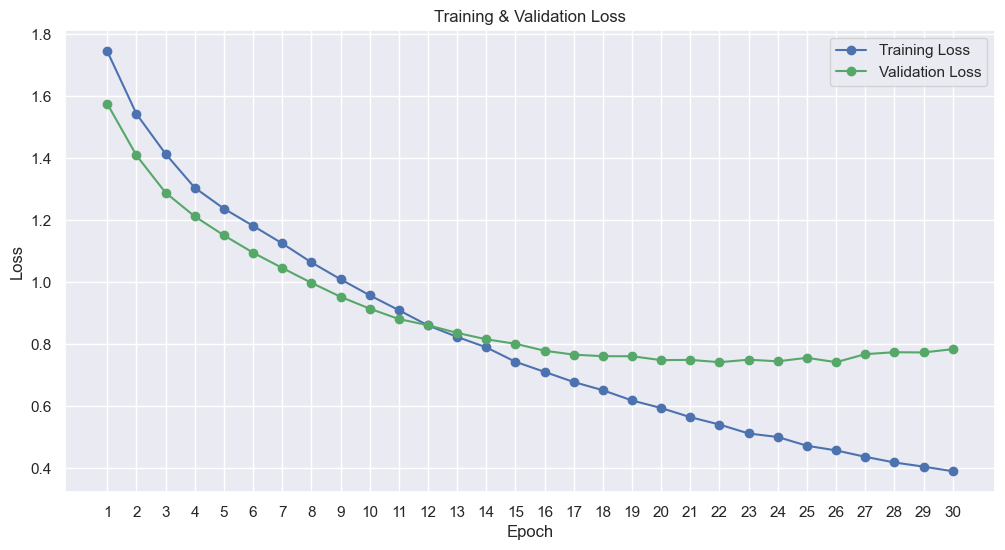

In [34]:
# plot loss results

def plot_losses(df):
    # set styling, plot size and font size as seaborn
    sns.set(style='darkgrid')
    sns.set(font_scale=1.0)
    plt.rcParams["figure.figsize"] = (12,6)

    # plot the learning curves
    plt.plot(df_stats['Train Loss'], 'b-o', label="Training Loss")
    plt.plot(df_stats['Val Loss'], 'g-o', label="Validation Loss")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(list(range(1, epochs+1)))
    return plt.show()

plot_losses(df_stats)

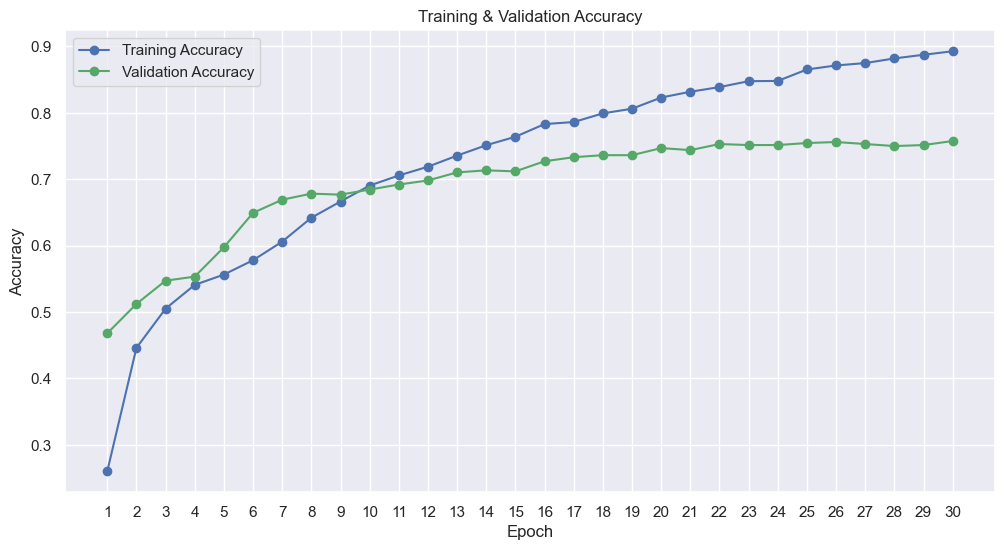

In [35]:
# plot accuracy results

def plot_accuracy_curves(df):
    # set styling, plot size and font size as seaborn
    sns.set(style='darkgrid')
    sns.set(font_scale=1.0)
    plt.rcParams["figure.figsize"] = (12,6)

    # plot the learning curves
    plt.plot(df_stats['Train Accuracy'], 'b-o', label="Training Accuracy")
    plt.plot(df_stats['Val Accuracy'], 'g-o', label="Validation Accuracy")

    # Label the plot.
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.xticks(list(range(1, epochs+1)))
    return plt.show()

plot_accuracy_curves(df_stats)

# Evaluate the net with test data

In [39]:
# evaluate the net with testing function on test data

def testing(model, dataloader, criterion):
    print("Evaluation on test data ... ")

    # set the model in evaluation mode
    model.eval()

    # empty variables
    total_accuracy = 0
    total_loss = 0
    total_f1 = 0
    total_recall = 0
    total_precision = 0
    total_predicted = 0
    total_y_true = 0
    predictions = []
    true_values = []

    # evaluate data in epochs - evaluation for one epoch
    for batch_index, data in enumerate(dataloader):

        #print("Batch index: ", batch_index)
        test_input, test_label = data

        true_labels = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_features = test_input['input_ids'].squeeze(1).to(device)

        # do not calculate gradients - gradients are necessary only for training
        with torch.no_grad():

            # forward propagation (evaluate model on test batch)
            output = model(input_features, mask)

            # calculate cross entropy loss for batch
            loss = criterion(output, true_labels.long())

            # get predictions
            _, predicted = torch.max(output, dim=1)

        # collect validation loss values
        total_loss += loss.item()

        # get values on list for classification report and confusion matrix
        predictions += predicted.detach().cpu().numpy().tolist()
        true_values += true_labels.cpu().numpy().tolist()
        
        # move logits and labels to CPU
        predicted = predicted.detach().cpu().numpy()
        y_true = true_labels.detach().cpu().numpy()
    
        # calculate accuracy
        total_accuracy += accuracy_score(y_true, predicted, 
                                               normalize=True,
                                               sample_weight=None)
        # calculate f1
        total_f1 += f1_score(y_true, predicted, 
                                   average='weighted', 
                                   labels=np.unique(predicted), 
                                   zero_division=0)
        # calculate precision
        total_precision += precision_score(y_true, predicted, 
                                                 average='weighted', 
                                                 labels=np.unique(predicted), 
                                                 zero_division=0)
        # calculate recall
        total_recall += recall_score(y_true, predicted, 
                                           average='weighted',
                                           labels=np.unique(predicted),
                                           zero_division=0)
    
    # report final accuracy of test data
    avg_accuracy = total_accuracy / len(dataloader)

    # report final f1 of test data
    avg_test_f1 = total_f1 / len(dataloader)

    # report final f1 of test data
    avg_precision = total_precision / len(dataloader)

    # report final f1 of test data
    avg_recall = total_recall / len(dataloader)

    # calculate the average loss of test data
    avg_test_loss = total_loss / len(dataloader)

    # record statistics of test data
    test_stats.append(
        {
            'Test Loss': avg_test_loss,
            'Test Accuracy': avg_accuracy,
            'Test Precision': avg_precision,
            'Test Recall': avg_recall,
            'Test f1': avg_test_f1
        }
    )
    
    # collect all predicted and true values of test data
    predictions = predictions
    true_values = true_values
    
    #return None
    
    # return predicted and true values
    return predictions, true_values

In [40]:
# test the model
test_stats = []
model.load_state_dict(torch.load('finbertLL-hs-strength-model1.pt'))
#print(model)

<All keys matched successfully>

In [41]:
predictions, true_values = testing(model, test_dataloader, criterion)
#print(predictions, true_values)

df_test_stats = pd.DataFrame(data=test_stats)
df_test_stats

Evaluation on test data ... 


,Test Loss,Test Accuracy,Test Precision,Test Recall,Test f1
0,0.762,0.738,0.794,0.788,0.772


In [42]:
#from sklearn.metrics import confusion_matrix, classification_report

class_names = ['0', '1', '2', '3', '4', '5']

print(classification_report(true_values, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       225
           1       0.44      0.44      0.44        63
           2       0.74      0.74      0.74       192
           3       0.66      0.78      0.72       139
           4       0.00      0.00      0.00        18
           5       0.47      0.29      0.36        24

    accuracy                           0.73       661
   macro avg       0.53      0.52      0.52       661
weighted avg       0.71      0.73      0.72       661



In [43]:
print(confusion_matrix(true_values, predictions))

[[199  18   6   1   0   1]
 [ 13  28  17   3   0   2]
 [  6  13 142  29   0   2]
 [  2   3  22 109   0   3]
 [  1   1   4  12   0   0]
 [  4   1   2  10   0   7]]


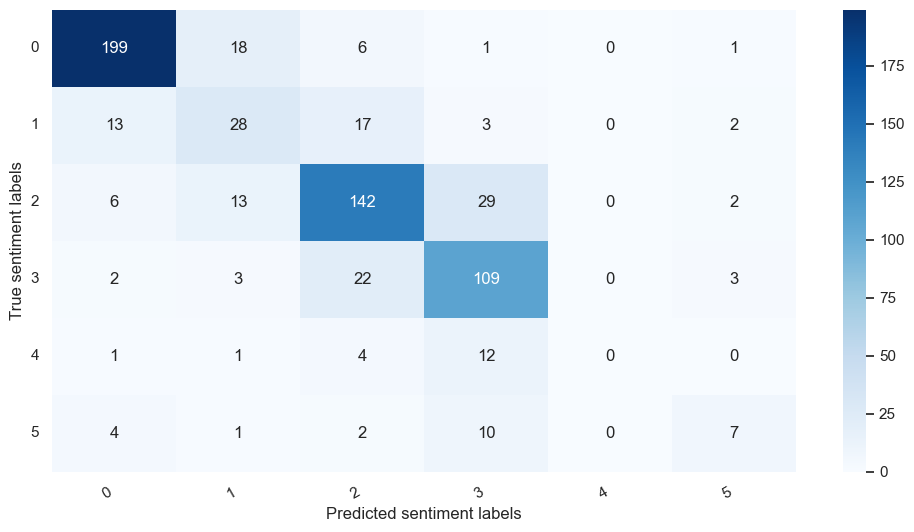

In [44]:
# https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment labels')
    plt.xlabel('Predicted sentiment labels');

cm = confusion_matrix(true_values, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [45]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=true_values, predict_vector=predictions)
cm.print_matrix()

Predict   0         1         2         3         4         5         
Actual
0         199       18        6         1         0         1         

1         13        28        17        3         0         2         

2         6         13        142       29        0         2         

3         2         3         22        109       0         3         

4         1         1         4         12        0         0         

5         4         1         2         10        0         7         




In [46]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.91125
F1 Macro                                                          0.52358
FPR Macro                                                         0.05775
Kappa                                                             0.63877
NPV Macro                                                         0.9435
Overall ACC                                                       0.73374
PPV Macro                                                         None
SOA1(Landis & Koch)                                               Substantial
TPR Macro                                                         0.52405
Zero-one Loss                                                     176

Class Statistics :

Classes                                                           0             1             2             3             4             5             
ACC(Accuracy)                                                     0.9

# Create table for performance score evaluation for test set

In [47]:
# get test data predictions
test_predictions, test_true_values = testing(model, test_dataloader, criterion)

#print(predictions, true_values)
#print(test_predictions)
#print(test_true_values)

print(len(test_predictions), len(test_true_values))

Evaluation on test data ... 
661 661


In [48]:
print(len(test_dataloader))

42


In [49]:
print(test_data['text'])

6325                                ählämsählämsuomineito
6589                            äärimmäisen vittuuntunut.
5267                           vittu mikä yksinhuoltajien
865                                    ai vittu ku sattuu
5515                                 vittu nrm 666 777 11
                              ...                        
5239                                 vittu mikä typerys!!
4075                                MatutUlosHyrylästäkin
1349    edäskin kaveri joutui lähtemään Saksaan asti t...
3467                                    Kuolemanporteilla
3596    kyllä vituttaa kattoo näitä musujen nuoleskelu...
Name: text, Length: 661, dtype: object


In [50]:
print(len(test_data['text']))

661


In [51]:
# create panda dataframe for test set
test_set_results = pd.DataFrame({'Sample':test_data['text'],'Actual Tags':test_data['HSstrength'],'Predicted Tags':predictions})
test_set_results

,Sample,Actual Tags,Predicted Tags
6325,ählämsählämsuomineito,2,0
6589,äärimmäisen vittuuntunut.,1,3
5267,vittu mikä yksinhuoltajien,3,2
865,ai vittu ku sattuu,2,2
5515,vittu nrm 666 777 11,2,3
...,...,...,...
5239,vittu mikä typerys!!,3,1
4075,MatutUlosHyrylästäkin,3,0
1349,edäskin kaveri joutui lähtemään Saksaan asti t...,0,0
3467,Kuolemanporteilla,0,2


# Analysis of new data
## Get predictions for new/raw/unknown data/subtitles/sentences

In [52]:
new_text_sample = "Se nekru, mutiainen, krokotiilinsyötti, viidakkoapina, Mississippin tuulikello - on Ron Stallworth, senkin punaniskainen pienikaluinen paskiainen!"


In [53]:
# tokenize samples with the Finnish Bert tokenizer
encoded_sample = BERT_TOKENIZER.encode_plus(new_text_sample,
                                            padding='max_length',
                                            max_length = MAX_LENGTH,
                                            add_special_tokens=True,
                                            truncation=True,
                                            return_token_type_ids=True,
                                            return_attention_mask=True,
                                            return_tensors='pt',
                                           )


In [54]:
class_names = ['0', '1', '2', '3', '4', '5']

input_ids = encoded_sample['input_ids'].to(device)
attention_mask = encoded_sample['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {new_text_sample}')
print(f'Sentiment  : {class_names[prediction]}')

#print(f'Sentiment  : {class_names[prediction]}')

#Review text: I love completing my todos! Best app ever!!!
#Sentiment  : positive

Review text: Se nekru, mutiainen, krokotiilinsyötti, viidakkoapina, Mississippin tuulikello - on Ron Stallworth, senkin punaniskainen pienikaluinen paskiainen!
Sentiment  : 2


## Create result table for test data

In [55]:
class_names = ['0', '1', '2', '3', '4', '5']

# Put inputs in x
x = test_data['text'].values

new_predictions = []

for sample in x:
    encoded_tokens = BERT_TOKENIZER.encode_plus(text=sample,
                                            padding='max_length',
                                            max_length = MAX_LENGTH,
                                            add_special_tokens=True,
                                            truncation=True,
                                            return_token_type_ids=True,
                                            return_attention_mask=True,
                                            return_tensors='pt',
                                           )
    input_ids = encoded_tokens['input_ids'].to(device)
    attention_mask = encoded_tokens['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    new_predictions.append(class_names[prediction])

#print(new_predictions)
len(new_predictions)

661

In [56]:
df_result = pd.DataFrame(new_predictions, columns=['sentiment_prediction'])

In [57]:
df_result['text'] = test_data['text'].values
df_result['sentiment_original'] = test_data['HSstrength'].values
df_result.head(50)

,sentiment_prediction,text,sentiment_original
0,2,ählämsählämsuomineito,2
1,1,äärimmäisen vittuuntunut.,1
2,2,vittu mikä yksinhuoltajien,3
3,2,ai vittu ku sattuu,2
4,2,vittu nrm 666 777 11,2
5,2,vittu käryää pahalle,3
6,2,vittu mikä fiilis,2
7,2,vittu just se!,2
8,3,Matu_tulee_kalliiksi,3
9,0,JatkoaXD,0
